In [1]:
from création_data import param_Dataset
import fonctions_ss as f
from IPython.display import display, Audio
from scipy.io.wavfile import write
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (12,4)

from tqdm import tqdm
from scipy.io import wavfile

In [2]:
Fe_init = 2**13
Fe_final = 2**17
print("Fe_init = ",Fe_init, "\nFe_final = ",Fe_final)
deltaf= 2000
Fes = np.arange(Fe_init,Fe_final,deltaf)
print("Longueur de Fes = ",len(Fes))

Fe_init =  8192 
Fe_final =  131072
Longueur de Fes =  62


In [3]:
# N_sample, param_dataset, xinB = param_Dataset(N_sample=200,
#                                             #  article_C = True,
#                                              acier_1C = True,
#                                              acier_2C = False, 
#                                              medium_1T = False, 
#                                              medium_2T = False,
#                                              metal_T = False,
#                                              plexi_T = True)

# T,rho_l,L,B,h,E_nu,rhoT,Lx,Ly = param_dataset[0]

# plot_axx = False
# err = []
# last_acc = np.array([], dtype=object)

# #adding a progress bar
# for i in tqdm(range(len(Fes))) :
    # print("fe = ",Fes[i])
    # acc_Nt = f.Main_ss(T,rho_l,L,B,h,E_nu,rhoT,Lx,Ly,xinB,Fes[i], obs="acc")
    
    # Exportation des données
    # wavfile.write("../../analyse_convergence_ss/acc_Nt_"+str(Fes[i])+".wav", Fes[i], acc_Nt/np.max(np.abs(acc_Nt)))

#     # last_acc = np.append(last_acc,acc_Nt)
#     # if i!=0 :
#     #     error = np.sqrt(np.sum((last_acc[0]-last_acc[1])**2))
#     #     err.append(error)
#     # last_acc = np.delete(last_acc,0)

#     # if plot_axx :
#     #     fig = plt.figure()
#     #     ax1 = fig.add_subplot(111)

#     #     ax1.plot(np.arange(len(acc_Nt))/Fes[i],acc_Nt,label="")
#     #     ax1.grid()
#     #     #ax1.legend()
#     #     ax1.set_xlabel("")
#     #     ax1.set_ylabel("")
#     #     ax1.set_title(r"")
#     #     ax1.set_xlim()
#     #     ax1.set_ylim()

#     #     fig.tight_layout()

#     #     plt.show()

#     # if i==2 :
#     #     break

In [4]:
#Chargement des données
import os

#creation de la liste
acc_Nfe = np.zeros(len(Fes), dtype=object)
acc_dico = {
    "Fe" : np.zeros(len(Fes), dtype=object),
    "acc" : np.zeros(len(Fes), dtype=object),
    "acc_resampled" : np.zeros(len(Fes), dtype=object), #acc resampled to Fe_init
    "filename" : np.zeros(len(Fes), dtype=object),
}
for i, file in enumerate(os.listdir("../../analyse_convergence_ss")) :
    #separation extension et nom
    name, ext = os.path.splitext(file)
    if ext == ".wav" :
        #recuperation de la frequence d'echantillonnage
        fe = int(name.split("_")[-1])
        #recuperation des donnees
        _, data = wavfile.read("../../analyse_convergence_ss/"+file)
        #ajout dans la liste
        acc_dico["Fe"][i] = fe
        acc_dico["acc"][i] = data
        acc_dico["filename"][i] = file


In [5]:
#Resampling des données
from scipy.signal import resample
for i in range(len(acc_dico["acc"])) :
    acc_dico["acc_resampled"][i] = resample(acc_dico["acc"][i],len(acc_dico["acc"][0]))

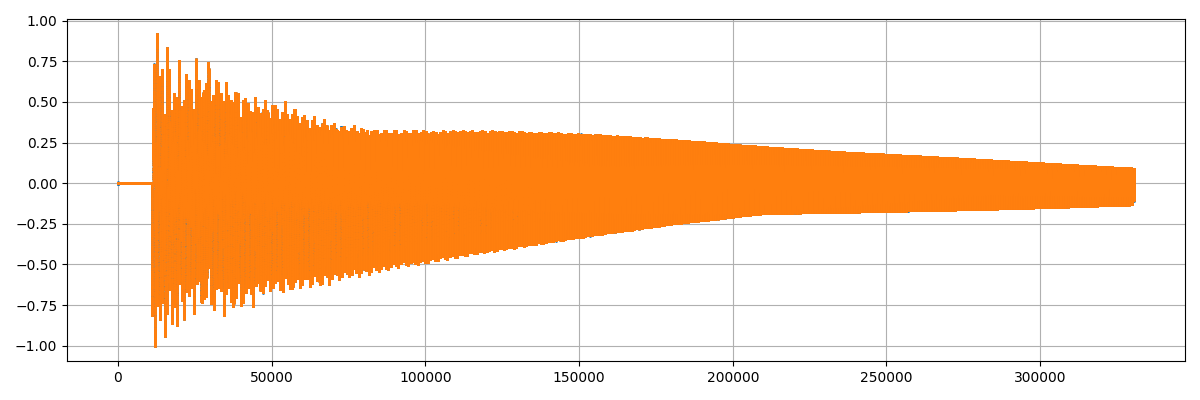

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(acc_dico["acc_resampled"][-2],label="", marker="o", markersize=1, ls="")
ax1.plot(acc_dico["acc_resampled"][0],label="", marker="o", markersize=1, ls="")
ax1.grid()
#ax1.legend()
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title(r"")
ax1.set_xlim()
ax1.set_ylim()

fig.tight_layout()

plt.show()

In [7]:
#Calcul de l'erreur et du coefficient de correlation
from scipy.signal import correlate
err = []
corr = []
phase_shift = []
for i in range(len(acc_dico["acc_resampled"])-1) :
    corr_i = correlate(acc_dico["acc_resampled"][i],acc_dico["acc_resampled"][i+1], mode="full")
    corr.append(np.max(np.abs(corr_i)))
    max_idx = np.argmax(np.abs(corr_i))
    #getting correlation lags
    lags = np.arange(-len(acc_dico["acc_resampled"][i])+1,len(acc_dico["acc_resampled"][i]))
    
    #Computing error with phase correction
    if lags[max_idx] > 0 : #si le décalage est positif, c'est que la seconde courbe est décalée vers la droite par rapport à la première, donc on décale la première vers la droite
        err.append(np.sqrt(np.sum((acc_dico["acc_resampled"][i][lags[max_idx]:]-acc_dico["acc_resampled"][i+1][:-lags[max_idx]])**2))/len(acc_dico["acc_resampled"][i][lags[max_idx]:]))
    
    elif lags[max_idx] < 0 : #sinon, on décale la seconde vers la droit
        err.append(np.sqrt(np.sum((acc_dico["acc_resampled"][i][:lags[max_idx]]-acc_dico["acc_resampled"][i+1][-lags[max_idx]:])**2))/len(acc_dico["acc_resampled"][i][:lags[max_idx]]))
    else :
        err.append(np.sqrt(np.sum((acc_dico["acc_resampled"][i]-acc_dico["acc_resampled"][i+1])**2))/len(acc_dico["acc_resampled"][i]))
        
    #Computing phase shift
    phase_shift.append(lags[max_idx])

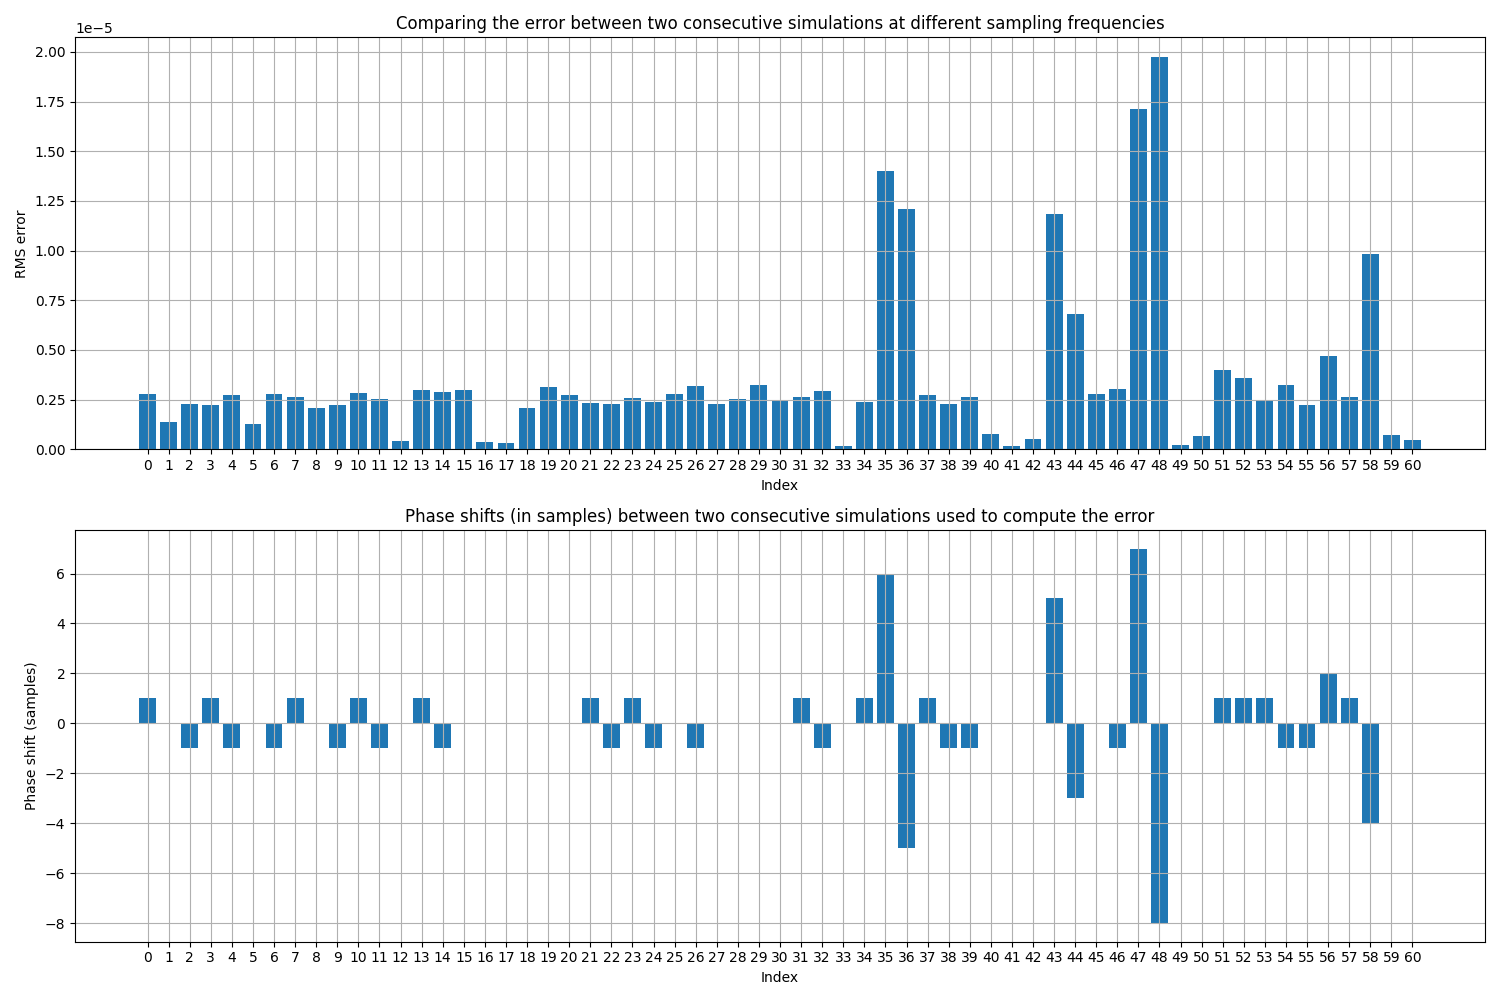

In [8]:
corr = np.array(corr)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.bar(np.arange(len(err)),err,label="")
ax1.grid()
#ax1.legend()
ax1.set_xticks(np.arange(len(err)))
# ax1.set_xticklabels(labels)
ax1.set_xlabel("Index")
ax1.set_ylabel("RMS error")
ax1.set_title(r"Comparing the error between two consecutive simulations at different sampling frequencies")
ax1.set_xlim()
# ax1.set_ylim(np.min(err),np.max(err))

ax2.bar(np.arange(len(corr)),phase_shift,label="")
ax2.grid()
#ax2.legend()
ax2.set_xticks(np.arange(len(corr)))
ax2.set_xlabel("Index")
ax2.set_ylabel("Phase shift (samples)")
ax2.set_title(r"Phase shifts (in samples) between two consecutive simulations used to compute the error")
ax2.set_xlim()
# ax2.set_ylim(np.min(phase_shift),np.max(phase_shift))

fig.tight_layout()

plt.show()

1.7127142442163567e-05


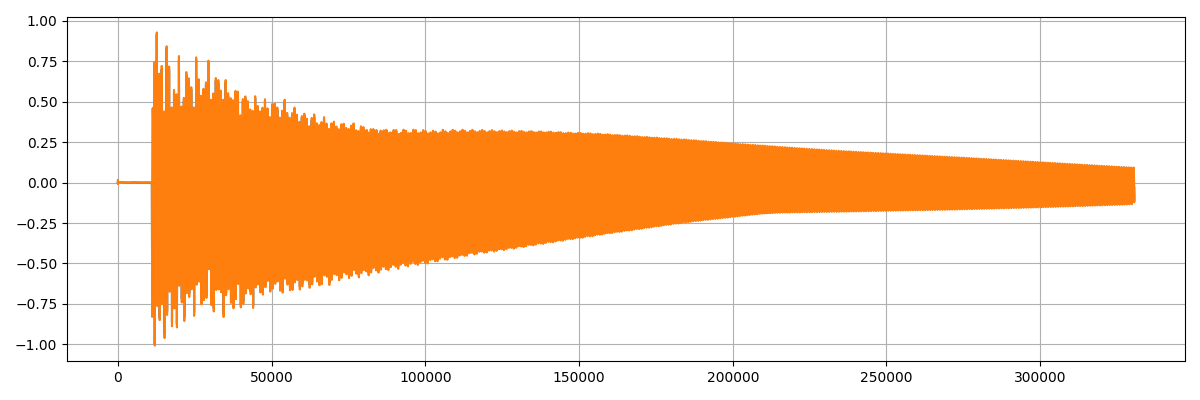

In [9]:
index = 47

#version avec index
correlation = correlate(acc_dico["acc_resampled"][index],acc_dico["acc_resampled"][index+1], mode="full")
max_idx = np.argmax(np.abs(correlation))
# getting correlation lags
lags = np.arange(-len(acc_dico["acc_resampled"][index])+1,len(acc_dico["acc_resampled"][index]))
if lags[max_idx] > 0 :
    acc1 = acc_dico["acc_resampled"][index][lags[max_idx]:]
    acc2 = acc_dico["acc_resampled"][index+1][:-lags[max_idx]]
    err = np.sqrt(np.sum((acc1-acc2)**2))/len(acc1)
elif lags[max_idx] < 0 :
    acc1 = acc_dico["acc_resampled"][index][:lags[max_idx]]
    acc2 = acc_dico["acc_resampled"][index+1][-lags[max_idx]:]
    err = np.sqrt(np.sum((acc1-acc2)**2))/len(acc1)
else :
    acc1 = acc_dico["acc_resampled"][index]
    acc2 = acc_dico["acc_resampled"][index+1]
    err = np.sqrt(np.sum((acc1-acc2)**2))/len(acc1)

print(err)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(acc1,label="", 
                    ls="-",
                    # marker='o',
                    # markersize=2,
                    )
ax1.plot(acc2,label="", 
                    ls="-",
                    # marker='o',
                    # markersize=2,
                    )
ax1.grid()
#ax1.legend()
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title(r"")
ax1.set_xlim()
ax1.set_ylim()

fig.tight_layout()

plt.show()

In [10]:
print(lags[max_idx])

7
